In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed

In [2]:
main_folder_path = '/datasets/amelatur/mimic_m1pz92hj/'
ids_file = pd.read_csv( main_folder_path + '0labels.txt')
patient_ids = ids_file['id']

vitals_path = '/datasets/amelatur/mimic_kih7jlb3/'

In [3]:
# RESPI FAILURE

sampling_rate_minutes = 30
steps_per_hour = 60//sampling_rate_minutes

ffill_p_f_hours = 2 * steps_per_hour
pao2_normal = 80.0
fio2_normal = 21.0

p_f_ratio_threshold = 300
window_ratio = 0.5
window_length = 2 * steps_per_hour

peep_interpolate_limit = 4 * steps_per_hour

# EXTRA STUFF
paco2_normal = 40
paco2_threshold = 45
ph_normal = 7.4
ph_threshold = 7.35



In [4]:
# CIRC FAILURE
sampling_rate_minutes = 30
steps_per_hour = 60//sampling_rate_minutes

ffill_lactate_hours = 7 * steps_per_hour
ffill_drugs_hours = 1 * steps_per_hour
ffill_map_hours = 5 * steps_per_hour

lactate_normal_value = 1.0
map_normal_value = 90.0

lactate_threshold = 2
map_threshold = 65
window_ratio = 2/3
window_length = 2 * steps_per_hour

# EXTRA STUFF
hr_normal_value = 80
hr_threshold = 100

In [5]:
# pick a random subset of patients 
# number_patients = 20000
# random_patient_ids = patient_ids.sample(n=number_patients, random_state=54)
random_patient_ids = patient_ids


In [6]:
# ICD CODES

respi_failure_string_0 = "respiratory failure"
respi_failure_string_1 = "respiratory distress"

circ_failure_string = "shock"

kidney_failure_string_0 = "acute kidney"
kidney_failure_string_1 = "acute renal"

sepsis_string_0 = "sepsis"
sepsis_string_1 = "septicemia"


In [7]:
# DEBUG CELL
p_id = random_patient_ids.iloc[101]
labs_file = pd.read_csv(main_folder_path + str(p_id) + '_all_vals.csv', index_col=False)
diags_file = pd.read_csv(main_folder_path + str(p_id) + '_diags.csv', index_col=False)
vitals_file = pd.read_csv(vitals_path + str(p_id) + '_vitals.csv', index_col=False)
vitals_file

,Unnamed: 0,time,id,heartrate,sbp,dbp,mbp,respiration,temperature,spo2
0,0,2186-12-13 15:52:00,31402461,82.0,NaN,NaN,NaN,20.0,NaN,NaN
1,1,2186-12-13 15:54:00,31402461,NaN,NaN,NaN,NaN,NaN,NaN,99.0
2,2,2186-12-13 16:00:00,31402461,63.0,NaN,NaN,NaN,14.0,NaN,94.0
3,3,2186-12-13 16:03:00,31402461,NaN,103.0,58.0,70.0,NaN,NaN,NaN
4,4,2186-12-13 16:40:00,31402461,NaN,NaN,NaN,NaN,NaN,37.17,NaN
5,5,2186-12-13 17:00:00,31402461,41.0,NaN,NaN,NaN,14.0,NaN,NaN
6,6,2186-12-13 17:01:00,31402461,NaN,78.0,59.0,67.0,NaN,NaN,NaN
7,7,2186-12-13 17:06:00,31402461,NaN,NaN,NaN,NaN,NaN,NaN,95.0
8,8,2186-12-13 18:00:00,31402461,84.0,NaN,NaN,NaN,22.0,NaN,98.0
9,9,2186-12-13 18:01:00,31402461,NaN,109.0,73.0,84.0,NaN,NaN,NaN


### RESPIRATORY FAILURE

In [17]:
def get_respi_fail (patient_id):

    labs_file = pd.read_csv(main_folder_path + str(patient_id) + '_all_vals.csv', index_col=False)
    labs_file['charttime'] = pd.to_datetime(labs_file['charttime'])
    labs_file = labs_file.sort_values(by='charttime').set_index('charttime')

    index_ = labs_file.index
    n_steps = len(labs_file.index)

    # annotate respiratory failure
    respi_status = pd.Series(0, index=index_)

    # P/F ratio
    if not (labs_file['po2'].isna().all() or n_steps < 24):
        exclusion_flag = 0
        p_f_raw = labs_file[['po2', 'fio2']].reindex(index_, method='ffill', limit=ffill_p_f_hours) 
        p_f_raw = p_f_raw.interpolate(limit=ffill_p_f_hours)
        p_f_raw['po2'] = p_f_raw['po2'].fillna(80.0) 
        p_f_raw['fio2'] = p_f_raw['fio2'].fillna(21.0)
        ratio = 100 * p_f_raw['po2'] / p_f_raw['fio2'] 

        p_f_ratio =  pd.Series(ratio, index=index_)


        # get ventilation status
        vent_df = labs_file['vent_presence']

        # peep 
        peep_interpolate_limit = 4 * steps_per_hour
        peep = labs_file['peep'].reindex(index_, method='ffill', limit=peep_interpolate_limit).squeeze()

        # take element-wise AND of peep and ventilation
        vent_peep_status_dense = vent_df.squeeze() & peep.squeeze() > 4

        peep[peep.isnull()] = 1
        peep[~peep.isnull()] = 0
        vent_peep_status_not_dense = (vent_df.squeeze()) & peep
        
        # annotate respiratory failure
        respi_status = pd.DataFrame(0, index=index_, columns=['respi_failure'])

        n_steps = len(vent_peep_status_not_dense)

        for i in range(n_steps):
            start_window = i
            end_window = min(n_steps, i + 2 * steps_per_hour)

            vent_win = np.array(vent_peep_status_dense[start_window:end_window])
            vent_win_not_dense = np.array(vent_peep_status_not_dense[start_window:end_window])
            p_f_win = np.array(p_f_ratio[start_window:end_window])
            
            no_vent_cond = np.sum((p_f_win < 300) & (vent_win == False)) >= 1/2 * len(vent_win)
            vent_cond_not_dense = np.sum((p_f_win < 300)& (vent_win_not_dense)) >= 1/2 * len(vent_win)
            vent_cond_dense = np.sum((p_f_win) < 300 & (vent_win)) >= 1/2 * len(vent_win)

            #vent_cond = np.sum((vent_win)) >= 2/3 * len(vent_win)

            final = no_vent_cond + vent_cond_not_dense + vent_cond_dense
            if final: 
                respi_status.iloc[i] = 1
    else:
        exclusion_flag = 1

    return respi_status, exclusion_flag
    

In [18]:
def get_respi_fail_unused (patient_id):

    #vitals_file = pd.read_csv(main_folder_path + str(patient_id) + '_vitals.csv', index_col=False)
    labs_file = pd.read_csv(main_folder_path + str(patient_id) + '_all_vals.csv', index_col=False)

    #vitals_file['time'] = pd.to_datetime(vitals_file['time'])
    labs_file['charttime'] = pd.to_datetime(labs_file['charttime'])

    #vitals_file = vitals_file.set_index('time')
    labs_file = labs_file.set_index('charttime')

    index_ = labs_file.index
    n_steps = len(labs_file.index)
    respi_status = pd.Series(0, index=index_)

    if not (labs_file['po2'].isna().all() or n_steps < 48):
    #if True:
        # P/F ratio
        excl_flag = 0
        p_f_raw = labs_file[['po2', 'spo2', 'fio2']]
        p_f_raw = p_f_raw.ffill(limit=ffill_p_f_hours)
        p_f_raw = p_f_raw.interpolate(limit=ffill_p_f_hours)
        p_f_raw['po2'] = p_f_raw['po2'].fillna(pao2_normal) 
        p_f_raw['spo2'] = p_f_raw['spo2'].fillna(95)
        p_f_raw['fio2'] = p_f_raw['fio2'].fillna(fio2_normal)

        po2 = p_f_raw['po2'].squeeze()
        spo2 = p_f_raw['spo2'].squeeze()
        fio2 = p_f_raw['fio2'].squeeze()

        paCO2_pH = labs_file[['pco2', 'ph']]
        paCO2_pH = paCO2_pH.ffill(limit=ffill_p_f_hours)
        paCO2_pH = paCO2_pH.interpolate(limit=ffill_p_f_hours)
        paCO2_pH['pco2'] = paCO2_pH['pco2'].fillna(paco2_normal) 
        paCO2_pH['ph'] = paCO2_pH['ph'].fillna(ph_threshold)
        paco2 = paCO2_pH['pco2'].squeeze()
        pH = paCO2_pH['ph'].squeeze()
        
        # annotate respiratory failure
    
        for i in range(n_steps):
            start_window = i
            end_window = min(n_steps, i + window_length)


            paco2_win = np.array(paco2[start_window:end_window])
            pH_win = np.array(pH[start_window:end_window])
            po2_win = np.array(po2[start_window:end_window])
            spo2_win = np.array(spo2[start_window:end_window])
            fio2_win = np.array(fio2[start_window:end_window])

            #respi_cond = (p_f_win < p_f_ratio_threshold) 
            hypoxia = np.sum(((po2_win < 55))) >= window_ratio * len(spo2_win)
            hypercapnia = np.sum((paco2_win > 45) & (pH_win < 7.35)) >= window_ratio * len(spo2_win)
            # hypoxia = np.sum(((po2_win < 55))) >= window_ratio * len(spo2_win)
            # hypercapnia = np.sum((paco2_win > 45)) >= window_ratio * len(spo2_win)
            # hypoxia = np.sum(((po2_win < 60) & (paco2_win < 50))) >= window_ratio * len(spo2_win)
            # hypercapnia = np.sum((paco2_win > 50) & (po2_win < 60) & (pH_win < 7.35)) >= window_ratio * len(spo2_win)
            final = hypoxia + hypercapnia
            if final: 
                respi_status.iloc[i] = 1
                
        #return respi_status, peep, vent_peep_status_dense, vent_peep_status_not_dense, p_f_ratio, labs_file['vent_presence']
        return respi_status, excl_flag
    else:
        excl_flag = 1
        return respi_status, excl_flag

### CIRCULATORY FAILURE

In [19]:
def get_circ_fail(patient_id):

    #vitals_file = pd.read_csv(main_folder_path + str(patient_id) + '_vitals.csv', index_col=False)
    labs_file = pd.read_csv(main_folder_path + str(patient_id) + '_all_vals.csv', index_col=False)

    #vitals_file['time'] = pd.to_datetime(vitals_file['time'])
    labs_file['charttime'] = pd.to_datetime(labs_file['charttime'])

    #vitals_file = vitals_file.set_index('time')
    labs_file = labs_file.set_index('charttime')
    index_ = labs_file.index
    n_steps = len(labs_file.index)
    circ_status = pd.Series(0, index=index_, name="circ")

    # if not (labs_file['mbp'].isna().all() or labs_file['uo_rt_6hr'].isna().all() or labs_file['heart_rate'].isna().all() or labs_file['lactate'].isna().all() or n_steps < 48):
    if not (n_steps < 24 or labs_file['mbp'].isna().all() or labs_file['lactate'].isna().all()):
        excl_flag = 0
        lactate_final = labs_file['lactate']
        lactate_final = lactate_final.ffill(limit=ffill_lactate_hours)
        lactate_final.loc[:lactate_final.first_valid_index()] = lactate_normal_value
        lactate_final = lactate_final.interpolate(limit=ffill_lactate_hours)
        lactate_final = lactate_final.fillna(lactate_normal_value)

        drug_df = labs_file['drug_presence'] # to series

        map_values = labs_file['mbp']
        map_values = map_values.ffill(limit=ffill_map_hours)
        map_values.loc[:map_values.first_valid_index()] = map_normal_value
        map_values = map_values.interpolate(limit=ffill_map_hours)
        map_values = map_values.fillna(map_normal_value)

        # Now calculate circ failure on imputed dataframes
        # final circ_status column filled with 0s
        event_window_length = window_length
        half_length = event_window_length//2

        # EXTRA STUFF: HR --> impute in the same manner as all values above (MAP, lactate)
        hr = labs_file['heart_rate']
        hr = hr.ffill(limit=ffill_map_hours)
        hr.loc[:hr.first_valid_index()] = hr_normal_value
        hr = hr.interpolate(limit=ffill_map_hours)
        hr = hr.fillna(hr_normal_value)

        # urine output
        uo = labs_file['uo_rt_6hr']
        uo = uo.ffill()
        uo = uo.fillna(1.5)

        for idx in range(n_steps):

            start_idx = max(0, idx - half_length)
            end_idx = min(n_steps, idx + half_length)

            map_wind = np.array(map_values[start_idx:end_idx+1])
            lactate_wind = np.array(lactate_final[start_idx:end_idx+1])
            drugs_wind = np.array(drug_df[start_idx:end_idx+1])
            hr_wind = np.array(hr[start_idx:end_idx+1])
            uo_wind = np.array(uo[start_idx:end_idx+1])

            pharma_cond = drugs_wind > 0
            map_cond = map_wind < 65
            hr_cond = hr_wind > hr_threshold
            uo_cond = uo_wind < 0.5

            map_full_cond = (map_cond | pharma_cond)
            #map_full_cond = map_cond
            lact_crit_arr = (lactate_wind > 2)
            map_state = np.sum(map_full_cond) >= window_ratio * len(map_full_cond)
            lac_state = np.sum(lact_crit_arr) >= window_ratio * len(map_full_cond)
            uo_state = np.sum(uo_cond) >= window_ratio * len(map_full_cond)
            hr_state = np.sum(hr_cond) >= 1/2 * len(map_full_cond)
            secondary = lac_state or uo_state
            if map_state and lac_state:
            # if (map_state and lac_state):
                circ_status.iloc[idx] = 1.0

        return circ_status, excl_flag
    else:
        excl_flag = 1
        return circ_status, excl_flag

### ACUTE KIDNEY INJURY

In [20]:
def get_kidney_fail(patient_id):
    #vitals_file = pd.read_csv(main_folder_path + str(patient_id) + '_vitals.csv', index_col=False)
    labs_file = pd.read_csv(main_folder_path + str(patient_id) + '_all_vals.csv', index_col=False)

    #vitals_file['time'] = pd.to_datetime(vitals_file['time'])
    labs_file['charttime'] = pd.to_datetime(labs_file['charttime'])

    #vitals_file = vitals_file.set_index('time')
    labs_file = labs_file.set_index('charttime')
    n_steps = len(labs_file.index)
    if (n_steps < 24 or labs_file['aki_stage'].isna().all()):
        excl_flag = 1
    else:
        excl_flag = 0
    return labs_file['aki_stage'], excl_flag

### SEPSIS

In [21]:
def get_sepsis(patient_id):

    detected_sepsis = ids_file[ids_file['id'] == patient_id]['sepsis'].values[0]
    
    labs_file = pd.read_csv(main_folder_path + str(patient_id) + '_all_vals.csv', index_col=False)
    labs_file['charttime'] = pd.to_datetime(labs_file['charttime'])
    labs_file = labs_file.set_index('charttime')
    n_steps = len(labs_file.index)
    excl_flag = 0
    if (n_steps < 24):
        excl_flag = 1
    if detected_sepsis == True:
        sepsis_time = pd.to_datetime(ids_file[ids_file['id'] == patient_id]['sepsis_time'].values[0])
        first_vital = min(labs_file.index)
        if (sepsis_time < first_vital):
            excl_flag = 1
    
    return detected_sepsis, excl_flag


### ICD CODES VALIDATION

In [22]:
def max_consecutive_ones(arr):
    max_ones = 0
    current_ones = 0

    for num in arr:
        if num == 1:
            current_ones += 1
            max_ones = max(max_ones, current_ones)
        else:
            current_ones = 0

    return max_ones

def compute_overlap(pt_id):
    diagnosis = pd.read_csv(main_folder_path + str(pt_id) + '_diags.csv', index_col=0)
    sepsis_pt, respi_pt, circ_pt, kidney_pt = None, None, None, None

    if diagnosis.empty == 0:

        # SEPSIS
        diag_sepsis = (diagnosis['0'].str.lower().str.contains(sepsis_string_0) | diagnosis['0'].str.lower().str.contains(sepsis_string_1)).values.any()
        detected_sepsis, excl_flag_sepsis = get_sepsis(pt_id)
            
        if excl_flag_sepsis == 1:
            detected_sepsis = None
            diag_sepsis = None
        if detected_sepsis and excl_flag_sepsis == 0:
            sepsis_pt = pt_id
        
        # RESPI
        diag_respi = (diagnosis['0'].str.lower().str.contains(respi_failure_string_0)).values.any() or (diagnosis['0'].str.lower().str.contains(respi_failure_string_1)).values.any()
        respi_status, excl_flag_respi = get_respi_fail(patient_id=pt_id)
        respi_status = respi_status.squeeze()
        detected_respi = False

        threshold = 3
        result_index = respi_status[respi_status.groupby((respi_status != respi_status.shift()).cumsum()[respi_status.eq(1)]).transform('count') > threshold]
        if result_index.empty == False:
            result_index = respi_status.index.get_loc(result_index.idxmax())
            detected_respi = True
            if result_index < 4 * 2:
                excl_flag_respi = 1
        else:
            result_index = None

        if excl_flag_respi == 1:
            detected_respi = None
            diag_respi = None
        if detected_respi and excl_flag_respi == 0:
            respi_pt = pt_id


        # CIRC
        diag_circ = (diagnosis['0'].str.lower().str.contains(circ_failure_string)).values.any()
        circ_status, excl_flag_circ = get_circ_fail(patient_id=pt_id)
        detected_circ = False

        threshold = 3
        result_index = circ_status[circ_status.groupby((circ_status != circ_status.shift()).cumsum()[circ_status.eq(1)]).transform('count') > threshold]
        if result_index.empty == False:
            result_index = circ_status.index.get_loc(result_index.idxmax())
            detected_circ = True
            if result_index < 4 * 2:
                excl_flag_circ = 1
        else:
            result_index = None

        if excl_flag_circ == 1:
            detected_circ = None
            diag_circ = None
        if detected_circ and excl_flag_circ == 0:
            circ_pt = pt_id

        # KIDNEY
        diag_kidney = (diagnosis['0'].str.lower().str.contains(kidney_failure_string_0)).values.any() or (diagnosis['0'].str.lower().str.contains(kidney_failure_string_1)).values.any()
        kidney_status, excl_flag_kidney = get_kidney_fail(patient_id=pt_id)
        detected_kidney = False


        if (kidney_status == 2).any():
            earliest_occurrence = np.argwhere(kidney_status.to_numpy() == 2)[0][0]
            end_idx = len(kidney_status)
            
            if earliest_occurrence < 4 * 2 or end_idx - earliest_occurrence < 4:
                excl_flag_kidney = 1
            detected_kidney = True
        if excl_flag_kidney == 1:
            detected_respi = None
            diag_respi = None
        if detected_kidney and excl_flag_kidney == 0:
            kidney_pt = pt_id

        #diag_respi, detected_respi, diag_sepsis, detected_sepsis = None, None, None, None
            
        #diag_respi, detected_respi, diag_sepsis, detected_sepsis, diag_circ, detected_circ = None, None, None, None, None, None
            


        return diag_respi, detected_respi, diag_circ, detected_circ, diag_kidney, detected_kidney, diag_sepsis, detected_sepsis, sepsis_pt, respi_pt, circ_pt, kidney_pt



In [23]:
temp = Parallel(n_jobs=-1)(delayed(compute_overlap)(pt_id) for (idx, pt_id) in tqdm(random_patient_ids.items()))



respi_actual = []
respi_pred = []

circ_actual = []
circ_pred = []

kidney_actual = []
kidney_pred = []

sepsis_actual = []
sepsis_pred = []

sepsis_pts = []
respi_pts = []
circ_pts = []
kidney_pts = []

for item in temp:
    if item !=None:
        diag_respi, detected_respi, diag_circ, detected_circ, diag_kidney, detected_kidney, diag_sepsis, detected_sepsis, sepsis_pt, respi_pt, circ_pt, kidney_pt = item

        respi_actual.append(diag_respi)
        respi_pred.append(detected_respi)

        circ_actual.append(diag_circ)
        circ_pred.append(detected_circ)

        kidney_actual.append(diag_kidney)
        kidney_pred.append(detected_kidney)

        sepsis_actual.append(diag_sepsis)
        sepsis_pred.append(detected_sepsis)

        sepsis_pts.append(sepsis_pt)
        respi_pts.append(respi_pt)
        circ_pts.append(circ_pt)
        kidney_pts.append(kidney_pt)

16it [00:20, 111.29it/s]/tmp/ipykernel_3310944/1191473108.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
/tmp/ipykernel_3310944/1694461004.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
/tmp/ipykernel_3310944/3544256476.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
/tmp/ipykernel_3310944/310529893.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
/tmp/ipykernel_3310944/1191473108.py:6: UserWarning: Could not infer format, so e

### DISPLAY RESULTS

               precision    recall  f1-score   support

No Respi Fail       0.82      0.52      0.63     16283
   Respi Fail       0.43      0.76      0.55      7903

     accuracy                           0.60     24186
    macro avg       0.63      0.64      0.59     24186
 weighted avg       0.69      0.60      0.61     24186



[Text(0, 0.5, 'No Respi Fail'), Text(0, 1.5, 'Respi Fail')]

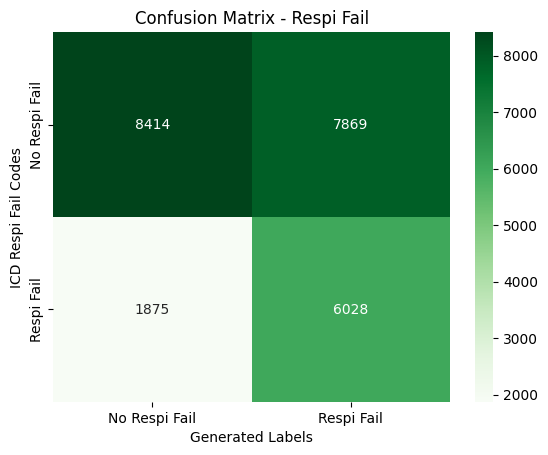

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

respi_actual = [x for x in respi_actual if x is not None]
respi_pred = [x for x in respi_pred if x is not None]

cm = confusion_matrix(respi_actual, respi_pred)     

# metrics
print(classification_report(respi_actual, respi_pred, target_names=['No Respi Fail', 'Respi Fail']))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Greens');  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Generated Labels');ax.set_ylabel('ICD Respi Fail Codes'); 
ax.set_title('Confusion Matrix - Respi Fail'); 
ax.xaxis.set_ticklabels(['No Respi Fail', 'Respi Fail']); ax.yaxis.set_ticklabels(['No Respi Fail', 'Respi Fail'])

              precision    recall  f1-score   support

   No Sepsis       0.94      0.60      0.73     60222
      Sepsis       0.30      0.80      0.43     12498

    accuracy                           0.64     72720
   macro avg       0.62      0.70      0.58     72720
weighted avg       0.83      0.64      0.68     72720



[Text(0, 0.5, 'No Sepsis'), Text(0, 1.5, 'Sepsis')]

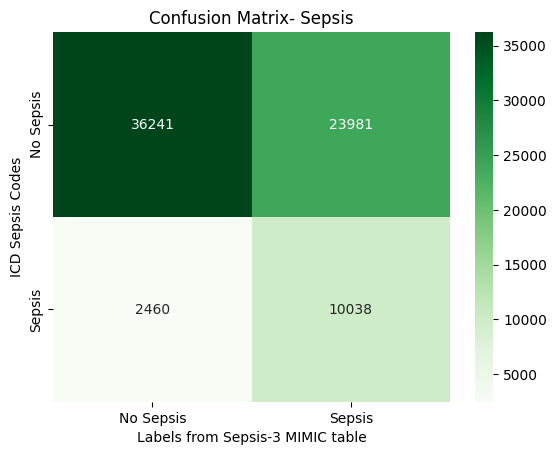

In [25]:
sepsis_actual = [x for x in sepsis_actual if x is not None]
sepsis_pred = [x for x in sepsis_pred if x is not None]

cm = confusion_matrix(sepsis_actual, sepsis_pred)     

# metrics
print(classification_report(sepsis_actual, sepsis_pred, target_names=['No Sepsis', 'Sepsis']))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Greens');  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Labels from Sepsis-3 MIMIC table');ax.set_ylabel('ICD Sepsis Codes'); 
ax.set_title('Confusion Matrix- Sepsis'); 
ax.xaxis.set_ticklabels(['No Sepsis', 'Sepsis']); ax.yaxis.set_ticklabels(['No Sepsis', 'Sepsis'])

                precision    recall  f1-score   support

No Kidney Fail       0.78      0.66      0.71     50446
   Kidney Fail       0.43      0.57      0.49     22274

      accuracy                           0.63     72720
     macro avg       0.60      0.61      0.60     72720
  weighted avg       0.67      0.63      0.64     72720



[Text(0, 0.5, 'No Kidney Fail'), Text(0, 1.5, 'Kidney Fail')]

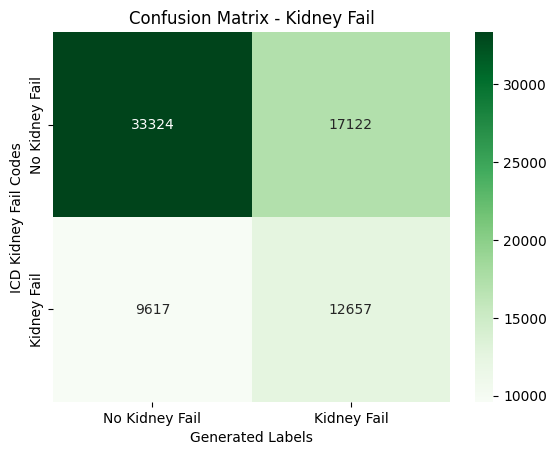

In [26]:
cm = confusion_matrix(kidney_actual, kidney_pred)     

# metrics
print(classification_report(kidney_actual, kidney_pred, target_names=['No Kidney Fail', 'Kidney Fail']))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Greens');  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Generated Labels');ax.set_ylabel('ICD Kidney Fail Codes'); 
ax.set_title('Confusion Matrix - Kidney Fail'); 
ax.xaxis.set_ticklabels(['No Kidney Fail', 'Kidney Fail']); ax.yaxis.set_ticklabels(['No Kidney Fail', 'Kidney Fail'])

              precision    recall  f1-score   support

No Circ Fail       0.79      0.91      0.85     26886
   Circ Fail       0.56      0.31      0.39      9492

    accuracy                           0.76     36378
   macro avg       0.67      0.61      0.62     36378
weighted avg       0.73      0.76      0.73     36378



[Text(0, 0.5, 'No Circ Fail'), Text(0, 1.5, 'Circ Fail')]

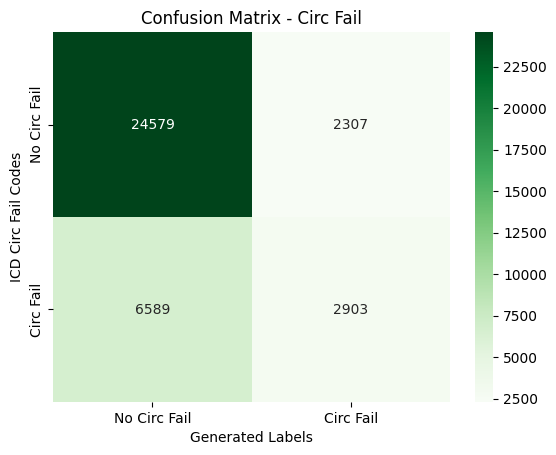

In [27]:
circ_actual = [x for x in circ_actual if x is not None]
circ_pred = [x for x in circ_pred if x is not None]

cm = confusion_matrix(circ_actual, circ_pred)     

# metrics
print(classification_report(circ_actual, circ_pred, target_names=['No Circ Fail', 'Circ Fail']))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Greens');  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Generated Labels');ax.set_ylabel('ICD Circ Fail Codes'); 
ax.set_title('Confusion Matrix - Circ Fail'); 
ax.xaxis.set_ticklabels(['No Circ Fail', 'Circ Fail']); ax.yaxis.set_ticklabels(['No Circ Fail', 'Circ Fail'])

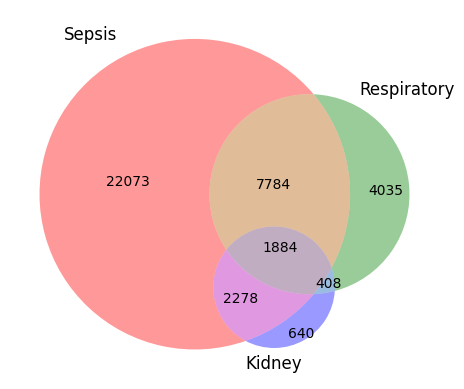

In [28]:
sepsis_pts = [x for x in sepsis_pts if x is not None]
respi_pts = [x for x in respi_pts if x is not None]
circ_pts = [x for x in circ_pts if x is not None]
kidney_pts = [x for x in kidney_pts if x is not None]

from matplotlib_venn import venn3

venn3([set(sepsis_pts), set(respi_pts), set(circ_pts)], ('Sepsis', 'Respiratory', 'Kidney'))

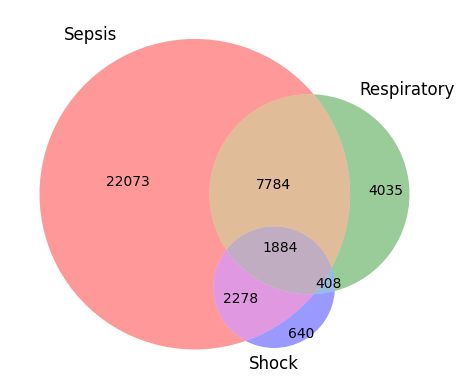

In [29]:
venn3([set(sepsis_pts), set(respi_pts), set(circ_pts)], ('Sepsis', 'Respiratory', 'Shock'))


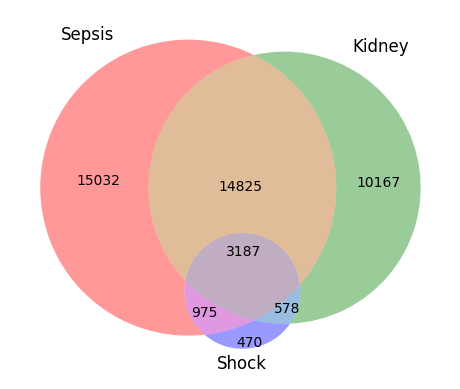

In [30]:
venn3([set(sepsis_pts), set(kidney_pts), set(circ_pts)], ('Sepsis', 'Kidney', 'Shock'))


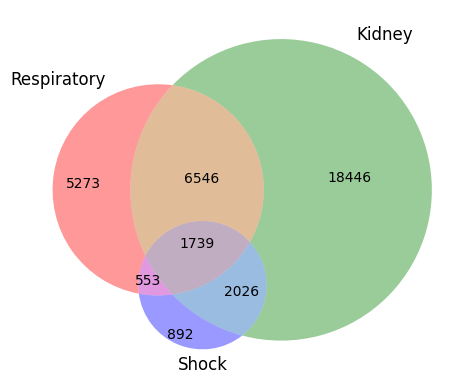

In [31]:
venn3([set(respi_pts), set(kidney_pts), set(circ_pts)], ('Respiratory', 'Kidney', 'Shock'))


### SAVE ICD PT IDs

In [60]:
main_folder_path = '/datasets/amelatur/mimic_m1pz92hj/'
ids_file = pd.read_csv( main_folder_path + '0labels.txt')
patient_ids = ids_file['id']

vitals_path = '/datasets/amelatur/mimic_kih7jlb3/'

save_folder_path = '/datasets/amelatur/data_slices/ICD_pt_ids/'

respi_failure_string_0 = "respiratory failure"
respi_failure_string_1 = "respiratory distress"

circ_failure_string = "shock"

kidney_failure_string_0 = "acute kidney"
kidney_failure_string_1 = "acute renal"

if not os.path.exists(save_folder_path):
    os.makedirs(save_folder_path)

In [61]:
kidney_ids_pos = []
kidney_ids_neg = []

circ_ids_pos = []
circ_ids_neg = []

respi_ids_pos = []
respi_ids_neg = []

for idx, pt_id in tqdm(random_patient_ids.items()):

    # read pt diagnosis strings
    diagnosis = pd.read_csv(main_folder_path + str(pt_id) + '_diags.csv', index_col=0)
    
    if diagnosis.empty == 0:

        #kidney string matching
        diag_kidney = (diagnosis['0'].str.lower().str.contains(kidney_failure_string_0)).values.any() or (diagnosis['0'].str.lower().str.contains(kidney_failure_string_1)).values.any()

        #circ string matching
        diag_circ = (diagnosis['0'].str.lower().str.contains(circ_failure_string)).values.any()

        #respi string matching
        diag_respi = (diagnosis['0'].str.lower().str.contains(respi_failure_string_0)).values.any() or (diagnosis['0'].str.lower().str.contains(respi_failure_string_1)).values.any()

        if diag_kidney:
            kidney_ids_pos.append(pt_id)
        else:
            kidney_ids_neg.append(pt_id)
        if diag_circ:
            circ_ids_pos.append(pt_id)
        else:    
            circ_ids_neg.append(pt_id)
        if diag_respi:
            respi_ids_pos.append(pt_id)
        else:
            respi_ids_neg.append(pt_id)
    



72741it [02:18, 523.54it/s]


In [63]:
kidney_save_path = save_folder_path + 'kidney/'

if not os.path.exists(kidney_save_path):
    os.makedirs(kidney_save_path)

with open(kidney_save_path + 'pos_pts.txt', 'w') as f:
    for pt in kidney_ids_pos:
        f.write("%s\n" % pt)

with open(kidney_save_path + 'neg_pts.txt', 'w') as f:
    for pt in kidney_ids_neg:
        f.write("%s\n" % pt)

circ_save_path = save_folder_path + 'circulatory/'

if not os.path.exists(circ_save_path):
    os.makedirs(circ_save_path)

with open(circ_save_path + 'pos_pts.txt', 'w') as f:
    for pt in circ_ids_pos:
        f.write("%s\n" % pt)

with open(circ_save_path + 'neg_pts.txt', 'w') as f:
    for pt in circ_ids_neg:
        f.write("%s\n" % pt)

respi_save_path = save_folder_path + 'respiratory_HiRID/'

if not os.path.exists(respi_save_path):
    os.makedirs(respi_save_path)

with open(respi_save_path + 'pos_pts.txt', 'w') as f:
    for pt in respi_ids_pos:
        f.write("%s\n" % pt)

with open(respi_save_path + 'neg_pts.txt', 'w') as f:
    for pt in respi_ids_neg:
        f.write("%s\n" % pt)